In [6]:
import pickle

# Load DataFrame from interim
with open('../data/interim/weatherAU-balanced.pkl', 'rb') as f:
    oversampled = pickle.load(f)

oversampled.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,0.0,0
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,0.0,0
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0.0,0.0,0
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0.0,1.0,0
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,0.2,0


In [7]:
# Imputation and transformation

# Find column with object data types
oversampled.select_dtypes(include=['object']).columns

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [8]:
# Impute categorical variable with mode
oversampled['Date'].fillna(oversampled['Date'].mode()[0], inplace=True)
oversampled['Location'].fillna(oversampled['Location'].mode()[0], inplace=True)
oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0], inplace=True)
oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0], inplace=True)
oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0], inplace=True)

In [9]:
# Convert categorical features to continuous features with LabelEncoding
from sklearn.preprocessing import LabelEncoder
label_encoder = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    label_encoder[col] = LabelEncoder()
    oversampled[col] = label_encoder[col].fit_transform(oversampled[col])

In [10]:
# Impute missing values with MICE (Multiple Imputation by Chained Equations)
import warnings
warnings.filterwarnings("ignore")

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
MiceImputed = oversampled.copy(deep=True)
mice_imputer = IterativeImputer()
MiceImputed.iloc[:,:] = mice_imputer.fit_transform(oversampled)

In [11]:
# Check missing values again
MiceImputed.isnull().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RISK_MM          0
RainTomorrow     0
dtype: int64

In [12]:
# Detect and eliminate outliers using interquartile
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Date             1537.000000
Location           25.000000
MinTemp             9.200000
MaxTemp            10.200000
Rainfall            2.400000
Evaporation         4.133406
Sunshine            5.909265
WindGustDir         9.000000
WindGustSpeed      19.000000
WindDir9am          8.000000
WindDir3pm          8.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        30.162567
Pressure9am         8.700000
Pressure3pm         8.800000
Cloud9am            4.000000
Cloud3pm            3.677065
Temp9am             9.300000
Temp3pm             9.800000
RainToday           1.000000
RISK_MM             5.200000
RainTomorrow        1.000000
dtype: float64


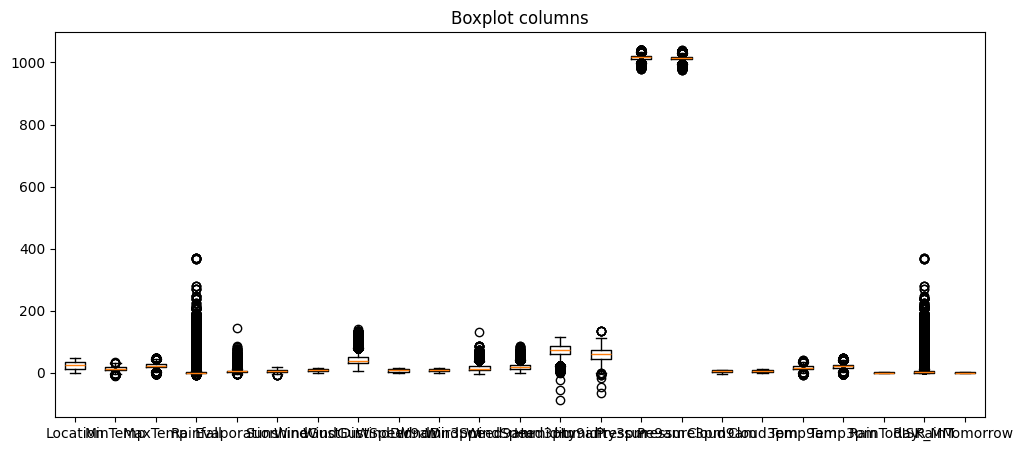

In [13]:
import matplotlib.pyplot as plt

cols_no_date = MiceImputed.drop(columns=['Date']).columns

data_to_plot = [MiceImputed[col].dropna().values for col in cols_no_date]

# Boxplot IQR to visualize outliers
plt.figure(figsize=(12, 5))
plt.boxplot(x=data_to_plot, labels=cols_no_date)
plt.title("Boxplot columns")
plt.show()

In [14]:
# Remove outliers from the dataset
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) | (MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

(156572, 24)

<Axes: >

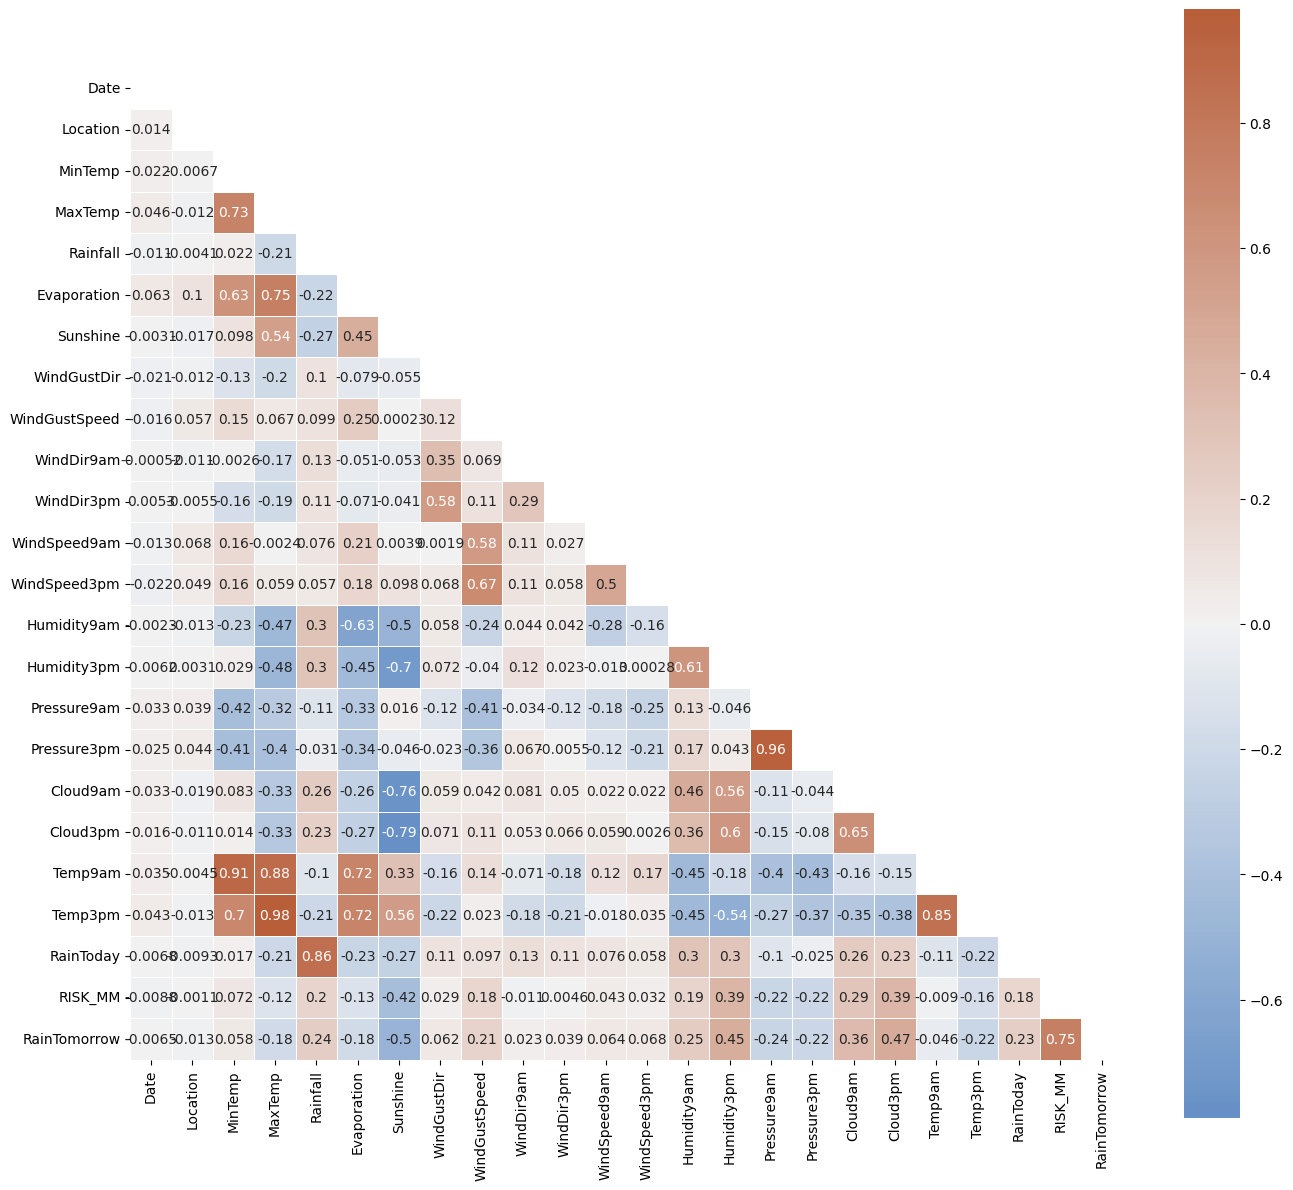

In [15]:
# Check multicollinearity using heatmap
import seaborn as sns
import numpy as np

corr = MiceImputed.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool_))
f, ax = plt.subplots(figsize=(16,16))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0, square=True, annot=True, linewidths=0.5, cbar_kws={"shrink": 0.9})

Hasil visualisasi heatmap menunjukkan features berikut memiliki korelasi positif kuat:
- MaxTemp dan MinTemp
- Evaporation dan MaxTemp
- Temp9am dan MinTemp
- Temp3pm dan Temp9am
- Pressure3pm dan Pressure 9am

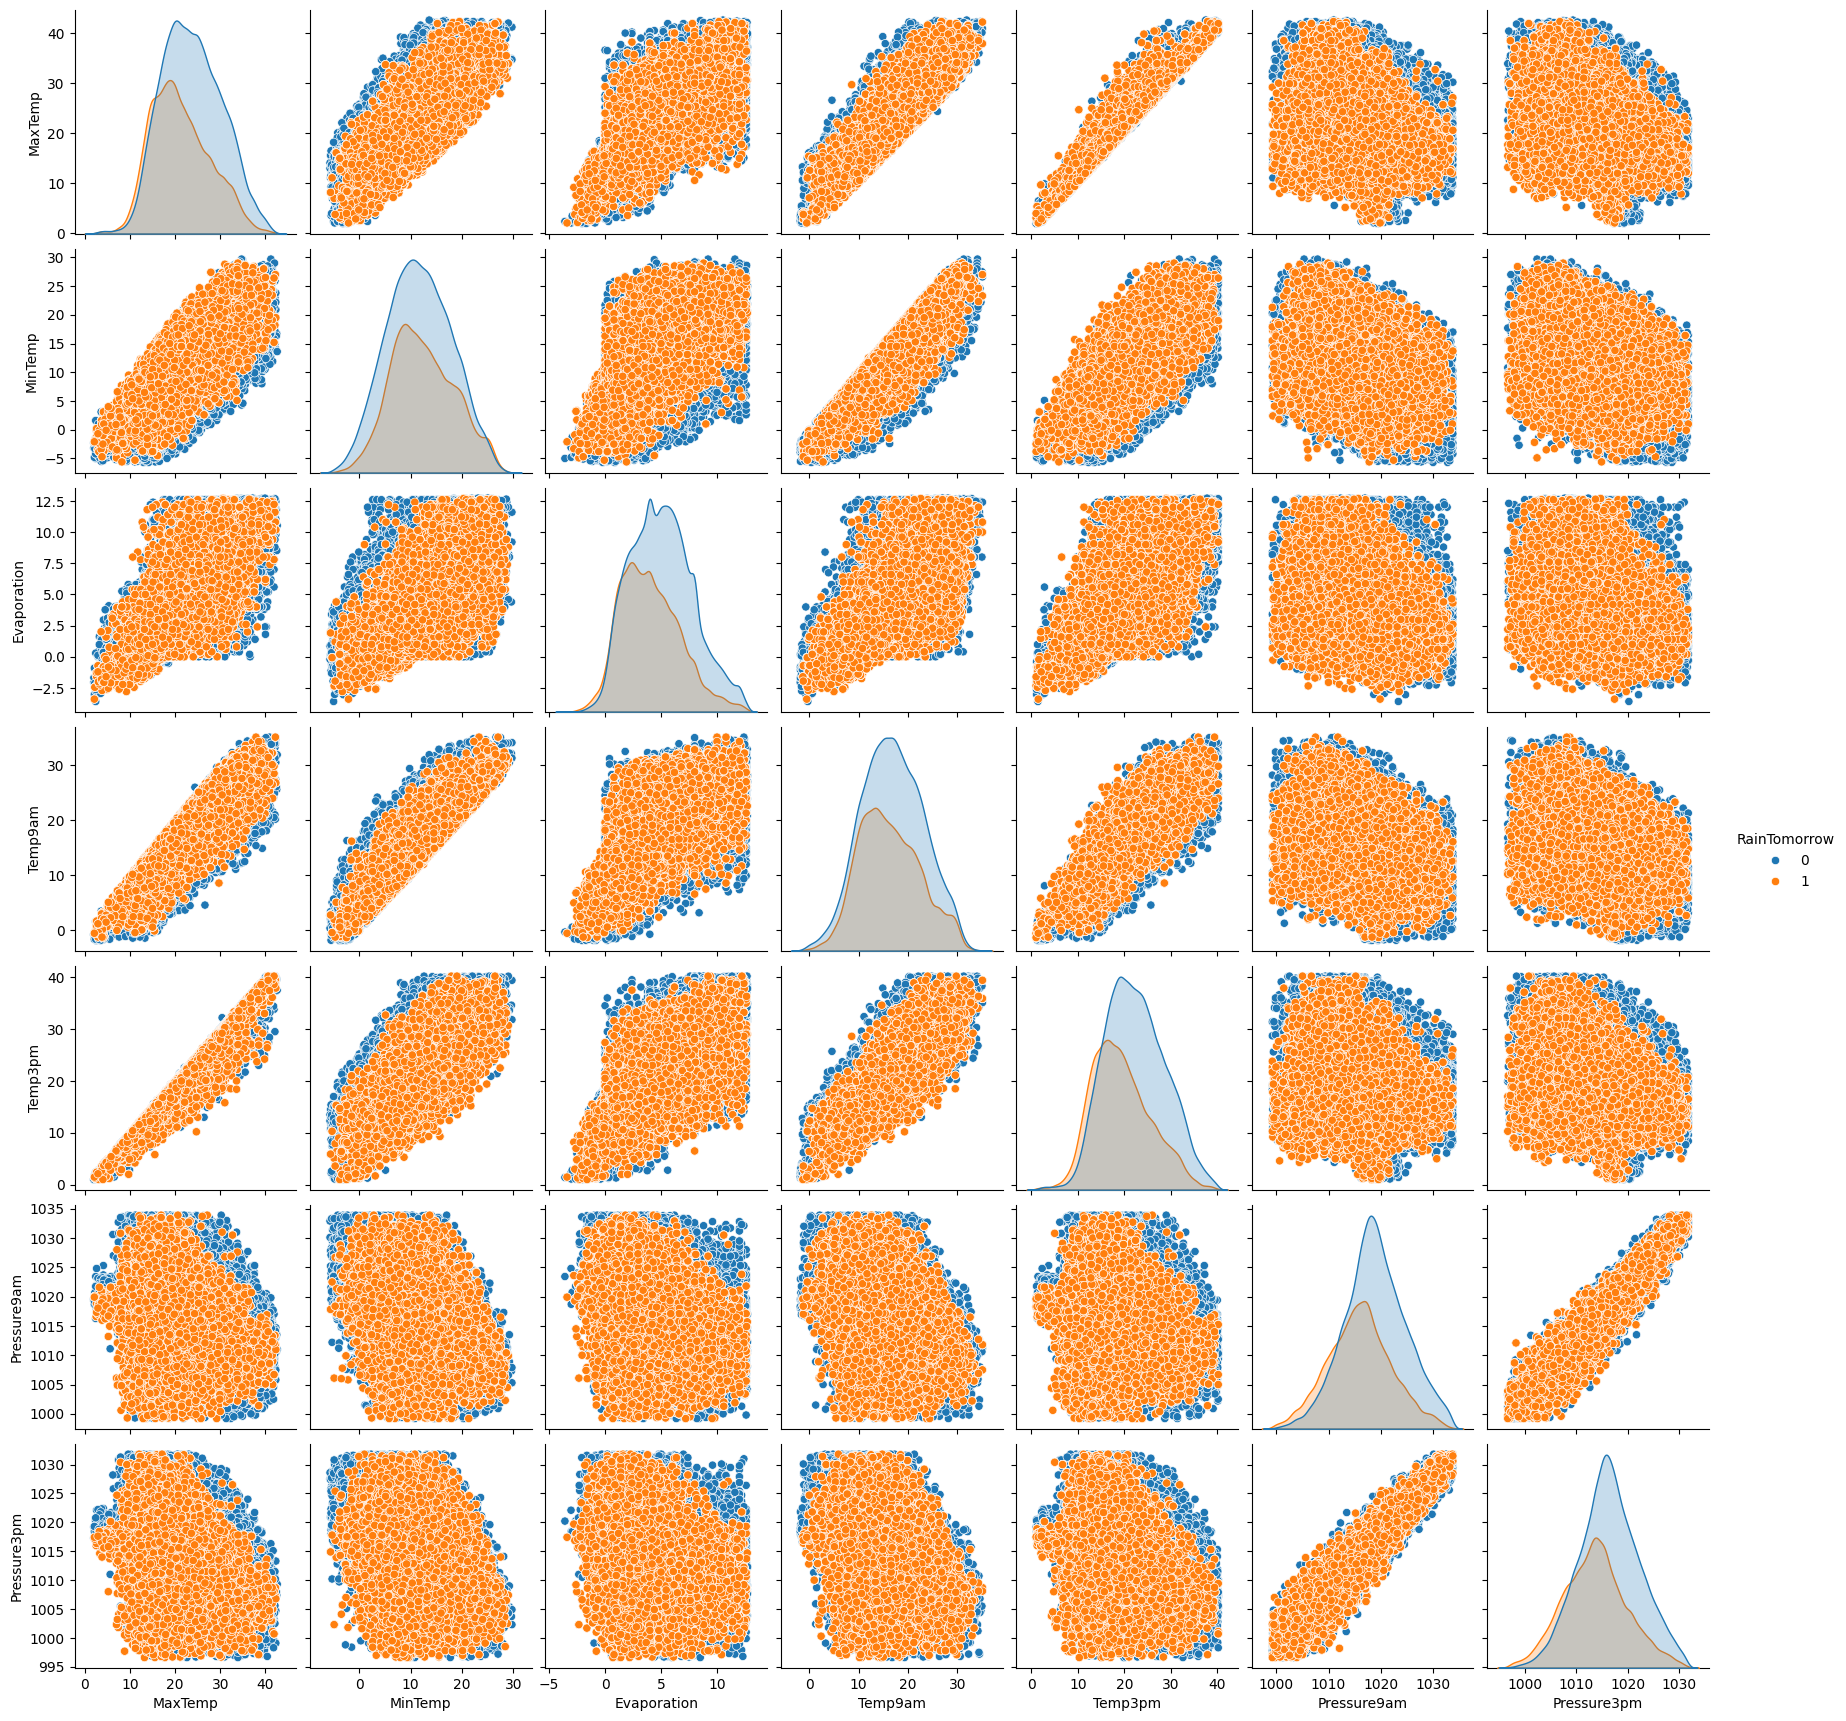

In [16]:
vars = ['MaxTemp', 'MinTemp', 'Evaporation', 'Temp9am', 'Temp3pm', 'Pressure9am', 'Pressure3pm']
hue = 'RainTomorrow'
sns.pairplot(data=MiceImputed, vars=vars, hue=hue)

In [17]:
# Feature Selection

# Standardize data
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
r_scaler = MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)

In [18]:
# Filtering method (chi-square value)
from sklearn.feature_selection import SelectKBest, chi2
X = modified_data.loc[:, modified_data.columns != 'RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Sunshine', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday',
       'RISK_MM'],
      dtype='object')


Sunshine, WindGustSpeed, Humidy9am, Humidity3pm, Pressure9am, dan Pressure3pm memiliki tingkat kepentingan lebih tinggi daripada feature lain.

In [19]:
# Feature selection by Wrapping Method (Random Forest)
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf

X = MiceImputed.drop('RainTomorrow', axis=1)
y = MiceImputed['RainTomorrow']
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)

['Sunshine', 'Cloud3pm', 'RISK_MM']
[0.00244243 0.00261143 0.00331928 0.00373582 0.01021336 0.0031645
 0.05960995 0.00158699 0.00831242 0.00179426 0.00180151 0.00166355
 0.00195499 0.00724807 0.03256454 0.00947782 0.01536364 0.02001214
 0.05375    0.00311367 0.00638441 0.00446976 0.74540546]


In [20]:
import os

if not os.path.exists('../data/processed'):
    os.makedirs('../data/processed')

# Save preprocessed data to processed data folder
with open('../data/processed/weatherAU-processed.pkl', 'wb') as f:
    pickle.dump(MiceImputed, f)